In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Oct  3 12:20:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-ef16c0cd-44e0-c4f1-d149-5a627ee2776a)


In [ ]:
# To unzip 
from zipfile import ZipFile
# file_name = "/content/drive/MyDrive/Colab Notebooks/data2.zip"
file_name = "/content/drive/MyDrive/Colab Notebooks/POMO_data_13092021.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
# import the libraries as shown below
 
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import image
import os, time, shutil
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
 
train_path = '/content/data_13092021/train'
valid_path = '/content/data_13092021/test'


In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
 
# ResNet50_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
ResNet50_model = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in ResNet50_model.layers:
    # layer.trainable = False
    layer.trainable = True


In [ ]:
# useful for getting number of output classes
folders = glob('/content/data_13092021/train/*')
folders

['/content/data_13092021/train/0',
 '/content/data_13092021/train/5',
 '/content/data_13092021/train/3',
 '/content/data_13092021/train/4',
 '/content/data_13092021/train/2',
 '/content/data_13092021/train/1']

In [ ]:
# our layers - you can add more if you want
x = Flatten()(ResNet50_model.output)

In [ ]:
x1 = Dense(512, activation='relu', name='fc1')(x)
x2 = Dense(256, activation='relu', name='fc2')(x1)
x3 = Dense(128, activation='relu', name='fc3')(x2)
x4 = Dense(64, activation='relu', name='fc4')(x3)
x5 = Dense(32, activation='relu', name='fc5')(x4)
x6 = Dense(16, activation='relu', name='fc6')(x5)
x7 = Dense(8, activation='relu', name='fc7')(x6)
prediction = Dense(len(folders), activation='softmax')(x7)

# prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=ResNet50_model.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# opt = keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Checkpoint's 
# https://keras.io/api/callbacks/model_checkpoint/
 
filepath="model_ResNet50_acc-{epoch:02d}-{accuracy:.3f}-{loss:.3f}-{val_accuracy:.3f}-{val_loss:.3f}.h5"
filepath1="model_ResNet50_loss-{epoch:02d}-{accuracy:.3f}-{loss:.3f}-{val_accuracy:.3f}-{val_loss:.3f}.h5"
# checkpoint = ModelCheckpoint(filepath, 
#                             #  monitor='val_loss',
#                              monitor='accuracy', 
#                             #  verbose=1, 
#                              save_best_only=True, 
#                             #  mode='min'
#                              )

checkpoint1 = ModelCheckpoint(filepath1, 
                            #  monitor='val_loss',
                             monitor='loss', 
                            #  verbose=1, 
                             save_best_only=True, 
                            #  mode='min'
                             )
callbacks_list = [checkpoint1] # checkpoint,


In [ ]:
# Use the Image Data Generator to import the images from the dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  #  shear_range = 0.1,
                                  #  zoom_range = 0.1,
                                   horizontal_flip = True)
 
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/data_13092021/train',
                                                 target_size = (224, 224),
                                                 batch_size = 128,
                                                 class_mode = 'categorical')
 
test_set = test_datagen.flow_from_directory('/content/data_13092021/test',
                                            target_size = (224, 224),
                                            batch_size = 128,
                                            class_mode = 'categorical')


Found 2814 images belonging to 6 classes.
Found 1386 images belonging to 6 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute

import datetime
time_start = datetime.datetime.now() 

start = time.time()
 
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=callbacks_list
)
print('\n\n')
print(f'Time: {round(time.time() - start,2)} sec.')
time_end = datetime.datetime.now()
print ('Time to run all : ', time_end - time_start)
 
model.save('ResNet50_model.h5')


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
22/22 [==============================] - 71s 3s/step - loss: 1.5556 - accuracy: 0.3614 - val_loss: 1459.1295 - val_accuracy: 0.2186


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
22/22 [==============================] - 63s 3s/step - loss: 1.3245 - accuracy: 0.4577 - val_loss: 2275.2622 - val_accuracy: 0.1667
Epoch 3/20
22/22 [==============================] - 63s 3s/step - loss: 1.3255 - accuracy: 0.4790 - val_loss: 928.5750 - val_accuracy: 0.1703
Epoch 4/20
22/22 [==============================] - 63s 3s/step - loss: 1.2340 - accuracy: 0.4879 - val_loss: 1184.3590 - val_accuracy: 0.1984
Epoch 5/20
22/22 [==============================] - 63s 3s/step - loss: 1.1918 - accuracy: 0.5092 - val_loss: 1964.9650 - val_accuracy: 0.1667
Epoch 6/20
22/22 [==============================] - 63s 3s/step - loss: 1.1485 - accuracy: 0.5380 - val_loss: 25.2603 - val_accuracy: 0.3571
Epoch 7/20
22/22 [==============================] - 63s 3s/step - loss: 1.0070 - accuracy: 0.5714 - val_loss: 11.0836 - val_accuracy: 0.2965
Epoch 8/20
22/22 [==============================] - 63s 3s/step - loss: 0.9638 - accuracy: 0.6109 - val_loss: 10.4306 - val_accuracy: 0.3730
Epoch 

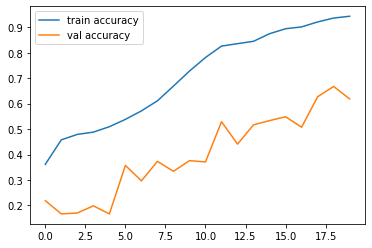

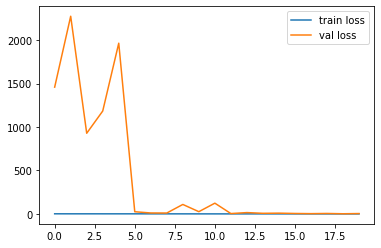

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy.png', dpi=200)
plt.show()
 
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('loss_and_val_loss.png', dpi=200)
plt.show()


In [ ]:
from glob import glob
import os
 
model = load_model('/content/model_ResNet50_loss-20-0.943-0.189-0.618-4.412.h5')
# model.summary()
 
data = []
labels = []
# classes = glob('/content/data_13092021/train/*') # data/train/* # data/test/*
# classes = glob('/content/data_13092021/test/*') # data/train/* # data/test/*
classes = glob('/content/data_13092021/val/*') # data/train/* # data/test/*
print('Number of classes : ', classes)
cur_path = os.getcwd()
print('cur_path : ', cur_path)


from PIL import Image
 
# Retrieving the images and their labels 
for i in range(len(classes)):
    # path = os.path.join(cur_path,'data_13092021/train',str(i))
    # path = os.path.join(cur_path,'data_13092021/test',str(i))
    path = os.path.join(cur_path,'data_13092021/val',str(i))
    print('path : ',path)
    images = os.listdir(path)
    # print('images : ',images)
    
    for a in images:
        try:
            image = Image.open(path + '/'+ a)            
            image = image.resize((224,224))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
print('loaded ...')

y_true = []
y_pred = []
 
for i in range(len(data)):
    x = data[i]
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)
    classes = model.predict(img_data)
    li = list(classes[0])
    y_pred.append(li.index(max(li)))
    y_true.append(labels[i])
    
    # print('y_true : ', y_true[i], ' y_pred : ', y_pred[i])
 
print('done...')


Number of classes :  ['/content/data_13092021/val/0', '/content/data_13092021/val/5', '/content/data_13092021/val/3', '/content/data_13092021/val/4', '/content/data_13092021/val/2', '/content/data_13092021/val/1']
cur_path :  /content
path :  /content/data_13092021/val/0
path :  /content/data_13092021/val/1
path :  /content/data_13092021/val/2
path :  /content/data_13092021/val/3
path :  /content/data_13092021/val/4
path :  /content/data_13092021/val/5
loaded ...
done...


In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_true,y_pred)
print(matrix, '\n')
 
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy, '\n')
print('Error rate: %f' % (1-accuracy), '\n')
 
from sklearn.metrics import classification_report
print("classification_report \n\n", classification_report(y_true,y_pred), '\n')
 
# kappa
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_true,y_pred)
print('Cohens kappa: %f' % kappa)
 
# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns 
 
# plt.rcParams['font.size'] = 20
# bg_color = (0,0.77,0.77)
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
 
# fig, ax = plt.subplots(1)
 
# plt.text(1,-.3, "Confusion Matrix", fontsize = 25, color='Black', fontstyle='italic')
 
# ax = sns.heatmap(matrix, annot=True, annot_kws={'size':15}, fmt="d", 
#                  robust=True, linewidths=.9, cmap="RdYlBu", square=True)
# # vmin=0, vmax=350,
# plt.savefig("model_VGG19.jpeg", dpi=200, facecolor=bg_color, transparent=True)
# plt.show()


[[ 22  18  65  11  15   9]
 [ 17  40  47  17  19   0]
 [  9   8  78  34  11   0]
 [ 14  15  18  72  17   4]
 [ 14  24  46   9  44   3]
 [  0   2   6   0   0 132]] 

Accuracy: 0.461905 

Error rate: 0.538095 

classification_report 

               precision    recall  f1-score   support

           0       0.29      0.16      0.20       140
           1       0.37      0.29      0.32       140
           2       0.30      0.56      0.39       140
           3       0.50      0.51      0.51       140
           4       0.42      0.31      0.36       140
           5       0.89      0.94      0.92       140

    accuracy                           0.46       840
   macro avg       0.46      0.46      0.45       840
weighted avg       0.46      0.46      0.45       840
 

Cohens kappa: 0.354286


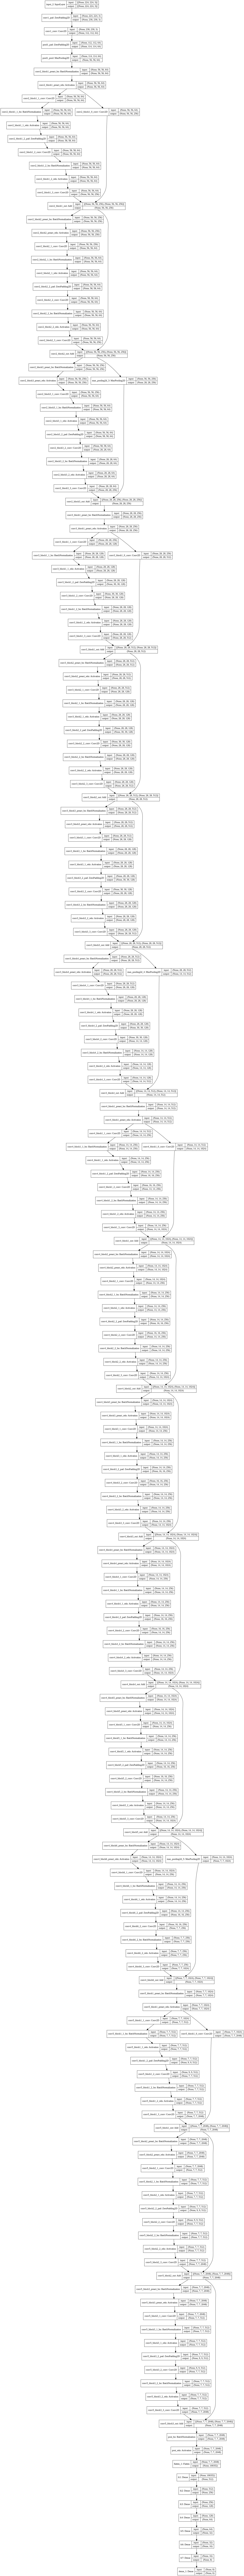

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_2',
 'conv1_pad',
 'conv1_conv',
 'pool1_pad',
 'pool1_pool',
 'conv2_block1_preact_bn',
 'conv2_block1_preact_relu',
 'conv2_block1_1_conv',
 'conv2_block1_1_bn',
 'conv2_block1_1_relu',
 'conv2_block1_2_pad',
 'conv2_block1_2_conv',
 'conv2_block1_2_bn',
 'conv2_block1_2_relu',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block1_out',
 'conv2_block2_preact_bn',
 'conv2_block2_preact_relu',
 'conv2_block2_1_conv',
 'conv2_block2_1_bn',
 'conv2_block2_1_relu',
 'conv2_block2_2_pad',
 'conv2_block2_2_conv',
 'conv2_block2_2_bn',
 'conv2_block2_2_relu',
 'conv2_block2_3_conv',
 'conv2_block2_out',
 'conv2_block3_preact_bn',
 'conv2_block3_preact_relu',
 'conv2_block3_1_conv',
 'conv2_block3_1_bn',
 'conv2_block3_1_relu',
 'conv2_block3_2_pad',
 'conv2_block3_2_conv',
 'conv2_block3_2_bn',
 'conv2_block3_2_relu',
 'max_pooling2d_3',
 'conv2_block3_3_conv',
 'conv2_block3_out',
 'conv3_block1_preact_bn',
 'conv3_block1_preact_relu',
 'conv3_block1_1_conv',
 'conv3_block1

In [ ]:
model.layers

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 230, 230, 3) dtype=float32 (created by layer 'conv1_pad')>,
 <KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'conv1_conv')>,
 <KerasTensor: shape=(None, 114, 114, 64) dtype=float32 (created by layer 'pool1_pad')>,
 <KerasTensor: shape=(None, 56, 56, 64) dtype=float32 (created by layer 'pool1_pool')>,
 <KerasTensor: shape=(None, 56, 56, 64) dtype=float32 (created by layer 'conv2_block1_preact_bn')>,
 <KerasTensor: shape=(None, 56, 56, 64) dtype=float32 (created by layer 'conv2_block1_preact_relu')>,
 <KerasTensor: shape=(None, 56, 56, 64) dtype=float32 (created by layer 'conv2_block1_1_conv')>,
 <KerasTensor: shape=(None, 56, 56, 64) dtype=float32 (created by layer 'conv2_block1_1_bn')>,
 <KerasTensor: shape=(None, 56, 56, 64) dtype=float32 (created by layer 'conv2_block1_1_relu')>,
 <KerasTensor: shape=(None, 58, 58, 64) dtype=float32 (created by la

In [ ]:
# !rm -r *.h5
# !rm -r *.png
# !rm -r *.zip
# !rm -r 0 1 2 3 4 5 
# !rm -r data1

# !mkdir 0
# !mkdir 1
# !mkdir 2
# !mkdir 3
# !mkdir 4
# !mkdir 5

# !zip -r '00_test.zip' '0'
# !zip -r '11_test.zip' '1'
# !zip -r '22_test.zip' '2'
# !zip -r '33_test.zip' '3'
# !zip -r '44_test.zip' '4'
# !zip -r '55_test.zip' '5'

rm: cannot remove '*.h5': No such file or directory


In [ ]:

# from keras.models import load_model
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input
# import numpy as np
# import os, time
# import shutil
# from glob import glob

# import datetime
# time_start = datetime.datetime.now()

# co = 0
# allName = {
# 	0:'0',
#   1:'1',
#   2:'2',
#   3:'3',
#   4:'4',
#   5:'5'
# 	}
# model = load_model('/content/drive/MyDrive/Colab Notebooks/model_vgg16-12-0.971-0.153.h5')

# entries = os.listdir('/content/data_64/train')
# print(entries)

# for i in entries:
#   # path = sorted(glob('data/train/'+i))
#   path = 'data_64/train/'+i
#   # Datasets\train\0 No_DR
#   # print('path : '+path, '\t\t class : ',i)
#   img_list = os.listdir(path)
#   # print('img_list : ',img_list)
#   for img_name in img_list:
#     img_path = path+'/'+img_name
#     # print('img_path : ', img_path, '\n \t\t path : ',int(path[-1]))
#     img = image.load_img(img_path, target_size=(224, 224))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     img_data = preprocess_input(x)
#     classes = model.predict(img_data)
#     li = list(classes[0])
#     # for i in range(len(li)):
#     #   print(i,' : ', li[i]*100, '% .')
# #     # print('\n\n')
#     Name = allName.get(np.argmax(li))
#     # print('Name of class prediction : ',Name, '\n\n')
#     co = str(co)
#     to =  str(Name)+'/'+str(co)+'_'+img_name
#     if int(path[-1]) == int(Name):
#       dest = shutil.copyfile(img_path, to)
#       # print('copy : ', path, ' to : ', to, ' dest : ', dest)
#       # print('copy : ', img_path, ' to : ', to)
#       co = int(co)
#       # print('Co : ', co)
#       co+=1
    
#     # time.sleep(.1)

# time_end = datetime.datetime.now()

# print ('Time to run all : ', time_end - time_start)

# print('Done ...')



['0', '5', '3', '4', '2', '1']
Time to run all :  0:53:40.547271
Done ...
